In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pickle
import mplleaflet as mpl

sns.set()
%matplotlib inline

In [3]:
import unidecode

def normalizeSentence(sentence):
    
    temp = sentence.split(' ')
    new_sentence = []
    for word in temp:
        new_sentence.append(normalizeWord(word))
    new_sentence = ' '.join(new_sentence)
    
    return new_sentence

def normalizeWord(word):
    
    # lower case word
    word = word.lower()
    
    # remove accents
    word = unidecode.unidecode(word)
    
    return word

def joinSeparetedWord(word):
    
    # removing aspas
    word = word.split('\'')
    word = '-'.join(word)
    
    # separete words from word
    word = word.split()
    
    # join separeted words by '-'
    word = '-'.join(word)
    
    return word

In [4]:
def selectByWord(word, sentences):
    # select subset of sentences that contains word
    # return indexs of sentences
    
    # normalize word
    normalized_word = normalizeWord(word)
    
    indexs = []
    
    for i, sentence in enumerate(sentences):
        # normalize sentence
        normalized_sentence = normalizeSentence(sentence)
        
        if normalized_word in normalized_sentence:
            #print(i, normalized_sentence)
            indexs.append(i)
    return indexs

In [5]:
def selectDfRowsByWord(data, word, column):
    '''
    Select specific rows that contains especific word in the column
    '''
    
    sentences = np.array(data[column].unique())

    # find sentences
    idxs = selectByWord(word, sentences)
    obj_sentences = sentences[idxs]

    servicos = pd.DataFrame()
    for sentence in obj_sentences:

        # select rows of exemplo
        temp = data[data[column] == sentence]

        # concatenate
        servicos = pd.concat([servicos, temp])
    try:
        temp = len(servicos[column].unique())
    except:
        print(word + ': Not found')
    
    return servicos.copy()

In [6]:
def calcDespesa(date, base, programa = None):
    '''
    Cálculo da despesa: empenhado - anulacao + reforco
    date: [{year}, {month}]
    base: pd.DataFrame
    programa: {str}
    '''
    year = date[0]
    month = date[1]
    
    temp = base.copy()
    if programa is not None:
        temp = base[base['ds_programa'] == programa].copy()
    temp = temp[(temp['ano_exercicio'] == year) & (temp['mes_referencia'] == month)]
    empenhado = temp[temp['tp_despesa'] == 'empenhado']['vl_despesa_per_capita'].sum()
    anulacao = temp[temp['tp_despesa'] == 'anulacao']['vl_despesa_per_capita'].sum()
    reforco = temp[temp['tp_despesa'] == 'reforco']['vl_despesa_per_capita'].sum()
    
    despesa = empenhado - anulacao + reforco
    
    del temp
    return despesa

In [7]:
def yearToYearMonth(year):
    '''
    Return [{year}-01, {year}-02, ..., {year}-12]
    '''
    
    dates = []
    for month in range(1, 13):
        if month < 10:
            str_month = '0'+str(month)
        else:
            str_month = str(month)
        dates.append(str(year)+'-'+str_month)
    return dates

In [8]:
def squaredDist(pos1, pos2):
    '''
    Return the squared distance between the pairs pos = (lat, long)
    '''
    return float((pos1[0] - pos2[0])**2 + (pos1[1] - pos2[1])**2)

In [9]:
def findKNeighboors(name, k):
    '''
    Return a list of the k nearst neighboors of {name} by lat and long
    '''
    # normalize name
    name = joinSeparetedWord(normalizeWord(name))
    
    # read csv of municipios
    data = pd.read_csv('datasets/municipios.csv')
    
    # normalize names of municipios
    data['Município'] = data['Município'].apply(normalizeWord)
    data['Município'] = data['Município'].apply(joinSeparetedWord)
    
    # select row by name
    reference = data[data['Município'] == name]
    # select latitude and longitude of reference
    lat, long = reference['Latitude'], reference['Longitude']
    reference_pos = (lat, long)
    
    dists = []
    for row in range(len(data)):
        selected = data.loc[row]
        # collect lat and long for selected municipio
        selected_pos = (selected[3], selected[4])
        
        # calculate dist between selected and reference
        dists.append(squaredDist(reference_pos, selected_pos))
    data['Distances'] = dists
    
    # sort by distance
    data = data.sort_values(by = 'Distances')
    
    # select k neighboors by it names
    k_neighboors = data['Município'].values[1:k+1]
    del data, dists
    return pd.DataFrame({'name': k_neighboors}).set_index('name')

In [10]:
class Municipio:
    '''
    
    Município
    
    '''
    
    def __init__(self, name, years = (2018, 2018), preparedData = True, k_neighboors = None, trainRNN = False,
                 isNeighboor = False, epochs = 500):
        
        self.keep_columns_ = ['ano_exercicio', 'mes_ref_extenso', 'mes_referencia', 'tp_despesa', 'vl_despesa',
                              'ds_funcao_governo', 'ds_subfuncao_governo', 'ds_programa', 'ds_acao']
        self.numeric_columns_ = ['ano_exercicio', 'vl_despesa', 'mes_referencia']
        
        self.years_ = np.arange(years[0], years[1]+1)
        self.name_ = normalizeWord(name)
        self.df_ = pd.DataFrame()
        self.population_ = None
        self.iamb_ = None
        self.regiao_ = None
        self.lat_ = None
        self.long_ = None
        self.preparedData_ = preparedData
        self.serie_ = pd.DataFrame()
        self.overview_ = pd.DataFrame()
        self.neighboors_ = None
        self.k_neighboors_ = k_neighboors
        self.isNeighboor_ = isNeighboor
        
        self.trainRNN_ = trainRNN
        self.predictions_ = None
        
        if not isNeighboor:
            print('## '+self.name_+' ##')
            print('# Reading and preparing data...')
        self.readPrepareData()
        
        if not isNeighboor:
            print('\n# Preparing serie...')
        self.prepareSerie()
        
        if not isNeighboor:
            print('\n# Preparing overview...')
            self.prepareOverview()
            
        if self.trainRNN_:
            if not isNeighboor:
                print('\n# Training RNN for {} epochs...'.format(epochs))
            self.trainRNN(epochs)
            
        if self.k_neighboors_ is not None:
            if not isNeighboor:
                print('\n# Calculating neighboors...')
            self.prepareNeighboors()
        if not isNeighboor:
            print('\nBase for {} is ready!!\n\n'.format(self.name_))
        
    def readPrepareData(self):
        if not self.isNeighboor_:
            print('> reading population, i-Amb, lat, long...')
        # reading population, i-amb...
        
        municipios_base = pd.read_csv('datasets/municipios.csv')
        municipios = municipios_base['Município'].values
        for i, municipio in enumerate(municipios):
            if joinSeparetedWord(normalizeWord(self.name_)) == joinSeparetedWord(normalizeWord(municipio)):
                self.population_ = municipios_base['Estimativa 2019'].values[i]
                self.lat_ = municipios_base['Latitude'].values[i]
                self.long_ = municipios_base['Longitude'].values[i]
                self.iamb_ = municipios_base['i-Amb'].values[i]
                self.regiao_ = municipios_base['Região Administrativa'].values[i]
        if self.population_ is None:
            print('Erro: population not found')
            return
        if not self.isNeighboor_:
            print('> reading and preparing despesas...')
        # reading despesas
        
        for year in self.years_:
            if self.preparedData_:
                # trying to read prepared data
                try:
                    aux = open('datasets/despesas/'+ str(year) +'/despesas-' + joinSeparetedWord(self.name_) + '-'+str(year)+'-prepared.csv', 'r')
                    aux.close()
                    del aux
                except:
                    self.preparedData_ = False
            if not self.preparedData_:
                # get unprepared data
                downloadDespesas([self.name_], year)
            temp = pd.read_csv('datasets/despesas/'+ str(year) +'/despesas-' + joinSeparetedWord(self.name_) + '-'+str(year)+'-prepared.csv', sep = ';',  encoding = "ISO-8859-1")
            temp = temp[self.keep_columns_]
            self.df_ = pd.concat([self.df_, temp]).reset_index(drop = True)
        del temp
        
        # add despesa per capita
        self.df_['vl_despesa_per_capita'] = self.df_['vl_despesa'].apply(lambda x : x/self.population_)
        
    def prepareSerie(self):
        
        dates = []
        for year in self.years_:
            for month in range(1, 13):
                if month < 10:
                    str_month = '0'+str(month)
                else:
                    str_month = str(month)
                dates.append(str(year)+'-'+str_month)
        self.serie_['date'] = dates
        for programa in self.df_['ds_programa'].unique():
            valor_programa = []
            for year in self.years_:
                for month in range(1, 13):
                    valor = calcDespesa([year, month], self.df_, programa)
                    valor_programa.append(valor)
            self.serie_[programa] = valor_programa
        
        self.serie_ = self.serie_.set_index('date')
        
        total = []
        for date in self.serie_.index:
            total.append(self.serie_.loc[date].values.sum())
        self.serie_['total'] = total
        
    def prepareOverview(self): 
        # para cada ano, visualizar as depesas
        for year in self.years_:
            dates = yearToYearMonth(year)
            temp = self.serie_.loc[dates]
            
            # dicionario dos programas para despesa
            despesas = pd.DataFrame({'ano_exercicio': [year]})
            
            for programa in self.serie_.columns:
                if programa == 'total':
                    continue
                despesas[programa] = [temp[programa].sum()]
            self.overview_ = pd.concat([self.overview_, despesas], axis = 0)
        self.overview_ = self.overview_.set_index('ano_exercicio')
    
    def trainRNN(self, epochs):
        '''
        Train RNN for {self.serie_['total']} and predict 12 months not seen yet
        '''
        self.predictions_ = pd.DataFrame({'date': yearToYearMonth(2019)})
        self.predictions_['total'] = trainPredictSeries(self.serie_['total'].values*self.population_, epochs = epochs)/self.population_
        self.predictions_ = self.predictions_.set_index('date')
        
    def prepareNeighboors(self):
        '''
        Select k neighboors and calculate anual despesa for last year of {self.years_}
        '''
        # add neighboors
        self.neighboors_ = findKNeighboors(self.name_, self.k_neighboors_)
        
        # calculate despesa for each neighboor
        despesas = []
        for neighboor_name in self.neighboors_.index:
            last_year = self.years_[len(self.years_) - 1]
            
            # create {Município} class with almost just needed variables
            neighboor = Municipio(neighboor_name, years = (last_year, last_year), isNeighboor = True)
            
            # take the total destesas for {last_year}
            despesas.append(neighboor.serie_['total'].sum())
            
            del neighboor
            
        self.neighboors_['total'] = despesas
        del despesas
            
        
        
    def plotSerie(self, programas = None):
        
        if programas is None:
            programas = ['total']
            
        plt.figure(figsize=(14,8))
        for programa in programas:
            plt.plot(self.serie_[programa], lw = 3, label = programa)
            aux = self.serie_[programa].values.reshape(-1)
            x = np.arange(len(aux))
            plt.fill_between(x, y1 = np.zeros(len(aux)), y2 = aux, lw = 3, alpha = 0.3)
        if programas[0] == 'total' and self.trainRNN_:
            plt.plot(self.predictions_['total'], lw = 3, label = 'predictions', color = 'coral')
            aux = self.predictions_['total'].values.reshape(-1)
            x_shift = 12*len(self.years_)
            x = np.arange(x_shift, len(aux)+x_shift)
            plt.fill_between(x, y1 = np.zeros(len(aux)), y2 = aux, lw = 3, alpha = 0.3, color = 'coral')
            
        plt.xticks(rotation=90)
        plt.title(self.name_ + ' - gestão ambiental')
        plt.ylabel('vl_despesa_per_capita (R$)')
        plt.xlabel('data')
        plt.legend()
        
    def plotOverview(self, years = None):
        
        if years is None:
            years = self.years_
        
        f, axs = plt.subplots(len(years), 1, figsize=(14,20))
        for i, year in enumerate(years):
            temp = self.overview_.sort_values(by = year, axis=1, ascending=True, inplace=False)
            temp = temp.loc[year]
            if len(years) == 1:
                temp.plot(kind = 'pie', cmap = 'viridis', ax = axs).set_title('Gestão Ambiental - Despesas')
            else:
                temp.plot(kind = 'pie', cmap = 'viridis', ax = axs[i]).set_title('Gestão Ambiental - Despesas')
    
    def plotNeighboorsCompare(self):
        plt.figure(figsize=(14,7))
        
        sns.stripplot(self.neighboors_, orient = 'v', color = 'green', size = 15)
        reference = self.predictions_['total'].values.sum()
        sns.stripplot([reference], orient = 'v', color = 'deeppink', size = 15)
        
        legend = ["Neighboors", self.name_]
        plt.title(self.name_ + ' - neighboors compare')
        plt.legend(legend)
        plt.ylabel('vl_despesa_per_capita_anual (R$)')

In [11]:
from zipfile import ZipFile
import urllib.request
import progressbar
import os

def downloadDespesas(names, year, unzip = True, prepareData = True):
        
    n = len(names)
    erros = []

    for i in range(n):
        name = names[i]

        # uniformalizing word for match
        name = normalizeWord(name)
        
        # replacing ' ' and '\'' to '-'
        name = joinSeparetedWord(name)
        
        # request download
        url = 'https://transparencia.tce.sp.gov.br/sites/default/files/csv/despesas-' + name + '-' + str(year) + '.zip'
        try:
            zipName = 'downloads/' + name + '-' + str(year) + '.zip'
            urllib.request.urlretrieve(url, zipName)
            if unzip:
                with ZipFile(zipName, 'r') as zipObj:
                    zipObj.extractall('datasets/despesas/' + str(year))
                try:
                    os.rename('datasets/despesas/' + str(year) + '/despesas-' + name + '-' + str(year) + '.zip.csv', 'datasets/despesas/' + str(year) + '/despesas-' + name + '-' + str(year) + '.csv')
                except:
                    None
                # prepare data with normalization of words and selecting 'gestao ambiental'
                if prepareData:
                    # read data
                    data = pd.read_csv('datasets/despesas/' + str(year) + '/despesas-' + name + '-' + str(year) + '.csv', sep = ';',  encoding = "ISO-8859-1")
                    
                    # remove nan values
                    data = data.dropna()

                    # string para float
                    data['vl_despesa'] = data.vl_despesa.apply(lambda x : float('.'.join(x.split(','))))
                    
                    # selecionando colunas e normalizando strings
                    columns = ['ano_exercicio', 'mes_ref_extenso', 'mes_referencia', 'tp_despesa', 'vl_despesa',
                              'ds_funcao_governo', 'ds_subfuncao_governo', 'ds_programa', 'ds_acao']
                    numeric_columns = ['ano_exercicio', 'vl_despesa', 'mes_referencia']
                    data = data[columns]
                    for column in columns:
                        if column in numeric_columns:
                             continue
                        data[column] = data[column].apply(lambda x : normalizeWord(x))
                    
                    # ajsutando nomes com . no meio
                    for column in ['ds_programa', 'ds_acao']:
                        data[column] = data[column].apply(lambda x : ''.join(x.split('.')))
                    # only gestao ambiental
                    data = data[data['ds_funcao_governo'] == 'gestao ambiental']
                    data.to_csv('datasets/despesas/' + str(year) + '/despesas-' + name + '-' + str(year) + '-prepared.csv', index = False, sep = ';')
                    
        except:
            erros.append(name)
        
    if len(erros) == 0:
        print('{}|{}\tDownloaded and prepared!'.format(names, year))
    else:
        print('Files not found:')
        print(erros)
    

In [12]:
def trainPredictSeries(series, epochs = 10000):
    '''
    Train a RNN and predict {predict_pediod}
    
    obs: series must met: len(series)%12 == 0
    '''
    
    batch_size = 12 # periodicidade de cada treino
    predict_period = 12 # numero de datas para serem preditas
    
    # (batches, size_of_batch, target_classes)
    X_batches = series[:-predict_period].reshape(-1, batch_size, 1)

    # a variável de predição é {batch_size} a frente em {series}
    y_batches = series[batch_size:].reshape(-1, batch_size, 1)

    # X_test são os ultimos {predict_period} valores
    X_test = series[-predict_period:].reshape(-1, batch_size, 1)

    # resetando definições dos grafos do tf
    tf.reset_default_graph()

    # numero de atributos na entrada
    unit_in = 1

    # numero de unidades na camada oculta
    unit_hid = 100

    # numero de unidaddes na saida
    unit_out = 1

    # placeholders
    x_ph = tf.placeholder(tf.float32, [None, batch_size, unit_in])
    y_ph = tf.placeholder(tf.float32, [None, batch_size, unit_out])

    # unidade da rede recorrente
    cell = tf.contrib.rnn.BasicRNNCell(num_units = unit_hid, activation = tf.nn.relu)
    # mapeamento para a camada de saida
    cell = tf.contrib.rnn.OutputProjectionWrapper(cell, output_size = 1)

    out_rnn, _ = tf.nn.dynamic_rnn(cell, x_ph, dtype = tf.float32)

    erro = tf.losses.mean_squared_error(labels = y_ph, predictions = out_rnn)
    otimizer = tf.train.AdamOptimizer()
    train = otimizer.minimize(erro)


    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        checkpoints = np.arange(0, epochs, int(epochs/3))
        
        # cost to breakdown loop
        eps = 0.01

        for epoch in range(epochs):
            _, cost = sess.run([train, erro], feed_dict = {x_ph: X_batches, y_ph: y_batches})
            if cost < 0.002:
                print('## Breakpoint: Cost of {0:1.4f} was met'.format(cost))
                break
            if epoch in checkpoints:
                print('> epoch: {0:1}\t|\tcost: {1:2.4f}'.format(epoch, cost))

        previsions = sess.run(out_rnn, feed_dict = {x_ph: X_test})
    
    # del variables
    del X_batches, y_batches, X_test, x_ph, y_ph, cell, out_rnn, _, erro, otimizer, train
    
    return np.ravel(previsions)

In [13]:
def readMunicipio(name, years = (2018, 2018), preparedData = True, k_neighboors = None, trainRNN = False,
                 isNeighboor = False, epochs = 500, getVariable = True):
    '''
    Read or create Muncipio class and return it
    '''
    
    municipio = None
    # try to read ready variable
    name = normalizeWord(name)
    name = joinSeparetedWord(name)
    if getVariable:
        try:
            with open('datasets/variables/'+name+'-variable', 'rb') as f:
                municipio = pickle.load(f)
        except:
            getVariable = False
    
    if not getVariable:
        municipio = Municipio(name = name, years = years, preparedData = preparedData,
                              k_neighboors = k_neighboors, trainRNN = trainRNN,
                              isNeighboor = isNeighboor, epochs = epochs)
        with open('datasets/variables/'+name+'-variable', 'wb') as f:
            pickle.dump(municipio, f)
    return municipio

In [25]:
name = 'Carapicuiba'
exemplo = readMunicipio(name, years = (2016, 2018), k_neighboors=3, trainRNN = True, epochs = 1500, getVariable = False)

## carapicuiba ##
# Reading and preparing data...
> reading population, i-Amb, lat, long...
> reading and preparing despesas...

# Preparing serie...

# Preparing overview...

# Training RNN for 1500 epochs...
> epoch: 0	|	cost: 16075189248.0000
> epoch: 500	|	cost: 96569672.0000
> epoch: 1000	|	cost: 61528036.0000

# Calculating neighboors...

Base for carapicuiba is ready!!




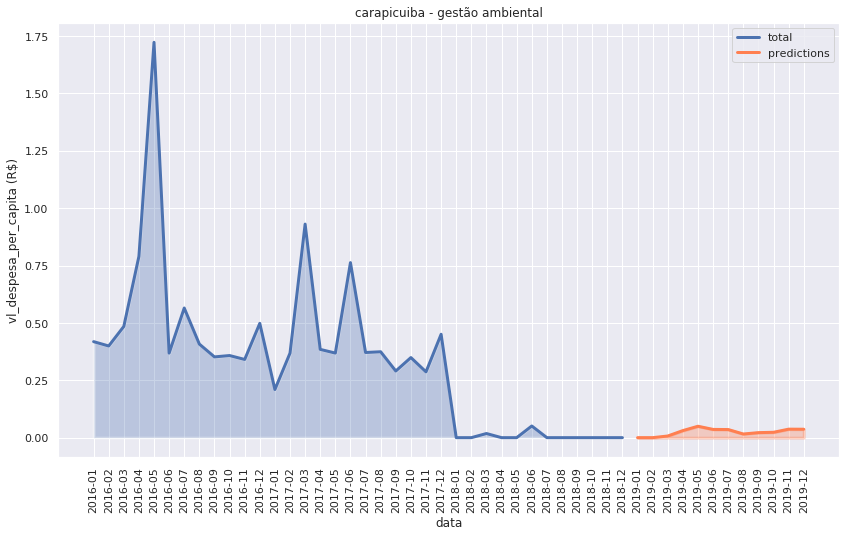

In [26]:
exemplo.plotSerie()

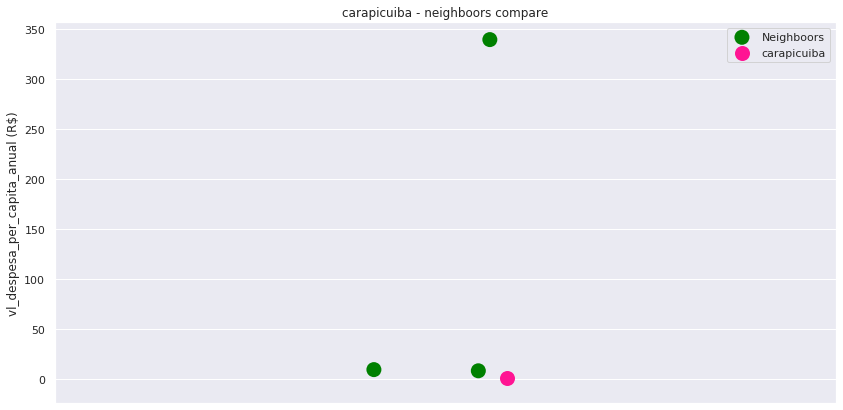

In [27]:
exemplo.plotNeighboorsCompare()

In [28]:
exemplo.neighboors_

,total
name,
barueri,339.314220
osasco,9.012979
jandira,7.827600


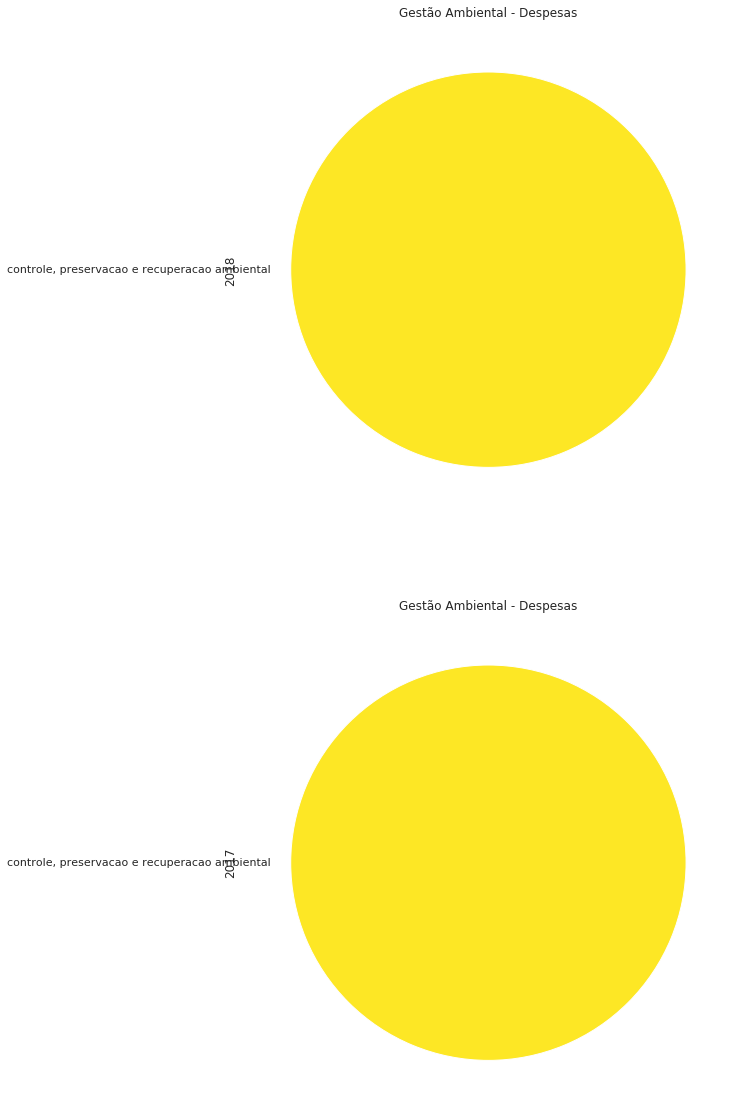

In [176]:
exemplo.plotOverview([2018, 2017])

In [177]:
exemplo.overview_

,"controle, preservacao e recuperacao ambiental",administracao e fiscalizacao de obras
ano_exercicio,,
2014,32.536819,0.000000
2015,23.413745,0.152683
2016,54.911338,0.000000
2017,54.504267,0.000000
2018,29.460628,0.000000


In [178]:
exemplo2 = Municipio(name, years = (2014, 2019))

# Reading and preparing data...
> reading population, i-Amb, lat, long...
> reading and preparing despesas...
['santos']|2019	Downloaded and prepared!

# Preparing serie...

# Preparing overview...

Base for santos is ready!!


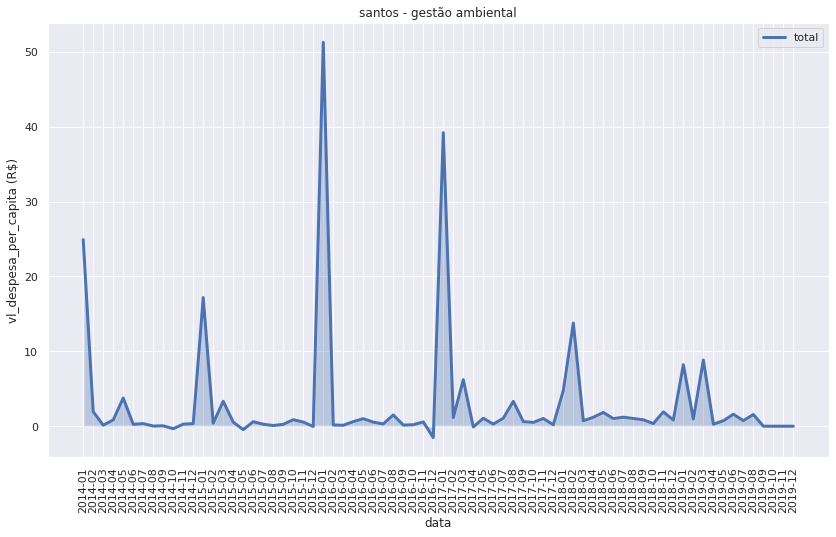

In [179]:
exemplo2.plotSerie()

### Loading collecting multiple data

In [205]:
municipios = pd.read_csv('datasets/municipios.csv')

In [256]:
municipios['i-Amb'].unique()

array(['B+', 'C', 'B', 'C+', 'A'], dtype=object)

In [206]:
municipios.head()

,Município,Posição,Estimativa 2019,Latitude,Longitude,Região Administrativa,Porte,i-Amb
0,Adamantina,184,35068,-21.6820,-51.0737,Região Administrativa de Presidente Prudente,Médio,B+
1,Adolfo,567,3562,-21.2325,-49.6451,Região Administrativa de São José do Rio Preto,Muito Pequeno,B+
2,Aguaí,176,36305,-22.0572,-46.9735,Região Administrativa de Campinas,Médio,C
3,Agudos,173,37214,-22.4694,-48.9863,Região Administrativa de Bauru,Médio,B+
4,Alambari,470,6025,-23.5503,-47.8980,Região Administrativa de Sorocaba,Pequeno,C


In [220]:
municipios['Município'] = municipios['Município'].apply(normalizeWord)
municipios['Município'] = municipios['Município'].apply(joinSeparetedWord)

In [257]:
def iambToNum(value):
    if value == 'C':
        return 5
    if value == 'C+':
        return 4
    if value == 'B':
        return 3
    if value == 'B+':
        return 2
    if value == 'A':
        return 1

In [260]:
municipio_names, latitudes, longitudes, variations, num_iamb = [], [], [], [], []
for regiao in municipios['Região Administrativa'].unique():
    temp = municipios[municipios['Região Administrativa'] == regiao]
    
    # collect the first {n} municipios
    n = 5
    names = temp.head(n)['Município'].values
    
    # for each name collect lat, long and name
    for name in names:
        temp = readMunicipio(name, years = (2014, 2018), k_neighboors=5, trainRNN = True, epochs = 1000)
        latitudes.append(temp.lat_)
        longitudes.append(temp.long_)
        municipio_names.append(temp.name_)
        variations.append(temp.neighboors_.values.mean() - temp.predictions_.values.sum())
        num_iamb.append(iambToNum(temp.iamb_))
        del temp
data = pd.DataFrame({'name': municipio_names, 'latitude': latitudes, 'longitude': longitudes,
                     'variation_per_capita': variations, 'i-Amb_num': num_iamb})

In [261]:
data.head()

,name,latitude,longitude,variation_per_capita,i-Amb_num
0,adamantina,-21.6820,-51.0737,-82.704833,2
1,alfredo-marcondes,-21.9527,-51.4140,6.920114,3
2,anhumas,-22.2934,-51.3895,16.629623,2
3,caiabu,-22.0127,-51.2394,12.620550,5
4,caiua,-21.8322,-51.9969,-38.364195,4


In [347]:
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))


def plot_color_gradients(name):
    fig, ax = plt.subplots(1, figsize=(14,1))
    fig.subplots_adjust(top=0.95, bottom=0.01, left=0.2, right=0.99)

    ax.imshow(gradient, aspect='auto', cmap=plt.get_cmap(name))
    pos = list(ax.get_position().bounds)
    x_text = pos[0] + 0.74
    y_text = pos[1] - 0.15
    fig.text(x_text, y_text, 'A                                                    B+                                                    B                                                    C+                                                    C', va='center', ha='right', fontsize=10)

    # Turn off *all* ticks & spines, not just the ones with colormaps.
    ax.set_axis_off()

In [350]:
plt.figure(figsize=(14, 8))
cmap = 'viridis'
cs = plt.scatter(data['longitude'], data['latitude'], s = data['variation_per_capita']*10, c = data['i-Amb_num'], cmap = cmap)
mpl.display()
#plot_color_gradients(cmap)

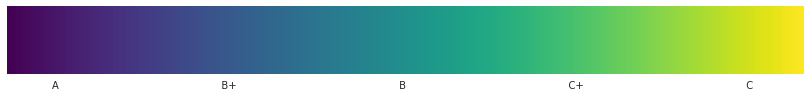

In [351]:
plot_color_gradients(cmap)